In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.0'

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer

MEASUREMENTS_PER_SAMPLE = 100
SAMPLE_STEP = 5
MEASUREMENTS_IN_SHUFFLE_GROUP = 300
CSV_FILE_PATH = '../adapted_gyroscope_datawithamount.csv'

df = pd.read_csv(CSV_FILE_PATH)

In [3]:
train_part_in_percents = 0.6
val_part_in_percents = 0.2
test_part_in_percents = 0.2

def split(samples, train_part_in_percents, val_part_in_percents, test_part_in_percents):
    train_part_end = int(train_part_in_percents * samples.shape[0])
    val_part_end = train_part_end + int(val_part_in_percents * samples.shape[0])
    test_part_end = val_part_end + int(test_part_in_percents * samples.shape[0])

    train_data = samples[0:train_part_end]
    val_data = samples[train_part_end:val_part_end]
    test_data = samples[val_part_end:test_part_end]
    
    return train_data, val_data, test_data

train_data_array = []
val_data_array = []
test_data_array = []

def shuffle_groups(l_df):
    number_of_groups = l_df.shape[0] // MEASUREMENTS_IN_SHUFFLE_GROUP 
    size_of_new_df = number_of_groups * MEASUREMENTS_IN_SHUFFLE_GROUP
    
    l_df = l_df[0: size_of_new_df]

    groups = l_df.values.reshape((number_of_groups, MEASUREMENTS_IN_SHUFFLE_GROUP, l_df.shape[-1]))
    
    randomize = np.arange(number_of_groups)
    np.random.shuffle(randomize)
    groups = groups[randomize]
    
    return pd.DataFrame(groups.reshape((size_of_new_df, l_df.shape[-1])), columns=l_df.columns)
    

for label in df['activity_type'].unique():
    l_df = df[df['activity_type'] == label]
    
    train_data, val_data, test_data = split(shuffle_groups(l_df), 0.6, 0.2, 0.2)
    
    train_data_array.append(train_data)
    val_data_array.append(val_data)
    test_data_array.append(test_data)

train_df = pd.concat(train_data_array)
val_df = pd.concat(val_data_array)
test_df = pd.concat(test_data_array)

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(117900, 8)
(39300, 8)
(39300, 8)


In [4]:
NUMBER_OF_FEATURES = len(train_df.columns) - 1

def preparaSamplesAndTargets(df):
    targets_and_samples = []

    def prepareForOneLabel(label, df):
        l_df = df[df['activity_type'] == label]
        l_df = l_df[l_df.columns[0:-1]]
        samples_number = (l_df.shape[0] - MEASUREMENTS_PER_SAMPLE) // SAMPLE_STEP
    
        def getSample(sample_index):
            sample_start_index = sample_index * SAMPLE_STEP
            sample_end_index = (sample_index * SAMPLE_STEP) + MEASUREMENTS_PER_SAMPLE
        
            return l_df[sample_start_index:sample_end_index].values.reshape(1, MEASUREMENTS_PER_SAMPLE, NUMBER_OF_FEATURES)
    
        return [[label, getSample(sample_index)] for sample_index in range(samples_number)]

    for label in df['activity_type'].unique():
        targets_and_samples.extend(prepareForOneLabel(label, df))

    samples = np.concatenate([ts[1] for ts in targets_and_samples])
    targets = LabelBinarizer().fit_transform(np.array([ts[0] for ts in targets_and_samples]))
    
    return samples, targets

train_data, train_labels = preparaSamplesAndTargets(train_df)
val_data, val_labels = preparaSamplesAndTargets(val_df)
test_data, test_labels = preparaSamplesAndTargets(test_df)

print(train_data.shape)
print(train_labels.shape)

print(val_data.shape)
print(val_labels.shape)

print(test_data.shape)
print(test_labels.shape)

(23500, 100, 7)
(23500, 4)
(7780, 100, 7)
(7780, 4)
(7780, 100, 7)
(7780, 4)


In [5]:
def shuffleSamplesAndTargets(samples, targets):
    randomize = np.arange(samples.shape[0])
    np.random.shuffle(randomize)
    samples = samples[randomize]
    targets = targets[randomize]
    
    return samples, targets

train_data, train_labels = shuffleSamplesAndTargets(train_data, train_labels)

In [6]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Conv1D(32, 3, activation='relu',
                        input_shape=(None, train_data.shape[-1])))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(32, 3, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dropout(0.35))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(test_labels.shape[-1], activation='softmax'))

In [7]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.0005),
              loss='mse',
              metrics=['accuracy'])

In [8]:
PATH_TO_BEST_MODEL = 'models/best_model.hdf5'

callbacks = [
    keras.callbacks.ModelCheckpoint(PATH_TO_BEST_MODEL, 
                                    monitor='val_acc', 
                                    verbose=0, 
                                    save_best_only=True, 
                                    save_weights_only=False, 
                                    mode='auto', 
                                    period=1)
]

%time history = model.fit(train_data, train_labels, epochs=100, callbacks=callbacks, batch_size=64, validation_data=(val_data, val_labels))

Train on 23500 samples, validate on 7780 samples
Epoch 1/100
23500/23500 [==============================] - 4s 152us/step - loss: 0.1402 - acc: 0.7174 - val_loss: 0.1334 - val_acc: 0.7332
Epoch 2/100
23500/23500 [==============================] - 3s 126us/step - loss: 0.1351 - acc: 0.7298 - val_loss: 0.1334 - val_acc: 0.7332
Epoch 3/100
23500/23500 [==============================] - 3s 124us/step - loss: 0.1350 - acc: 0.7297 - val_loss: 0.1336 - val_acc: 0.7332
Epoch 4/100
23500/23500 [==============================] - 3s 122us/step - loss: 0.1244 - acc: 0.7428 - val_loss: 0.1159 - val_acc: 0.7589
Epoch 5/100
23500/23500 [==============================] - 3s 125us/step - loss: 0.1126 - acc: 0.7642 - val_loss: 0.1088 - val_acc: 0.7686
Epoch 6/100
23500/23500 [==============================] - 3s 123us/step - loss: 0.1057 - acc: 0.7730 - val_loss: 0.0883 - val_acc: 0.8081
Epoch 7/100
23500/23500 [==============================] - 3s 124us/step - loss: 0.0788 - acc: 0.8243 - val_loss: 0.0

23500/23500 [==============================] - 4s 153us/step - loss: 0.0045 - acc: 0.9892 - val_loss: 0.0212 - val_acc: 0.9528
Epoch 60/100
23500/23500 [==============================] - 4s 151us/step - loss: 0.0047 - acc: 0.9888 - val_loss: 0.0198 - val_acc: 0.9551
Epoch 61/100
23500/23500 [==============================] - 4s 155us/step - loss: 0.0041 - acc: 0.9896 - val_loss: 0.0223 - val_acc: 0.9491
Epoch 62/100
23500/23500 [==============================] - 4s 154us/step - loss: 0.0044 - acc: 0.9896 - val_loss: 0.0212 - val_acc: 0.9526
Epoch 63/100
23500/23500 [==============================] - 4s 157us/step - loss: 0.0045 - acc: 0.9890 - val_loss: 0.0207 - val_acc: 0.9549
Epoch 64/100
23500/23500 [==============================] - 4s 161us/step - loss: 0.0044 - acc: 0.9896 - val_loss: 0.0217 - val_acc: 0.9518
Epoch 65/100
23500/23500 [==============================] - 4s 182us/step - loss: 0.0041 - acc: 0.9897 - val_loss: 0.0221 - val_acc: 0.9503
Epoch 66/100
23500/23500 [=======

              acc     val_acc        loss    val_loss
count  100.000000  100.000000  100.000000  100.000000
mean     0.966732    0.939990    0.015055    0.027613
std      0.060726    0.048195    0.029642    0.023864
min      0.717362    0.733162    0.003115    0.018479
25%      0.977521    0.949582    0.003963    0.020181
50%      0.987319    0.952892    0.005414    0.021236
75%      0.990234    0.955174    0.009559    0.022805
max      0.992085    0.959126    0.140198    0.133595


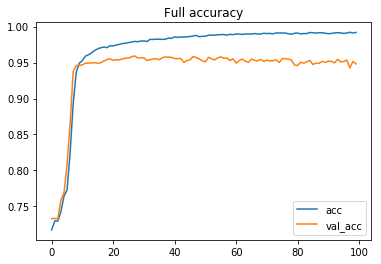

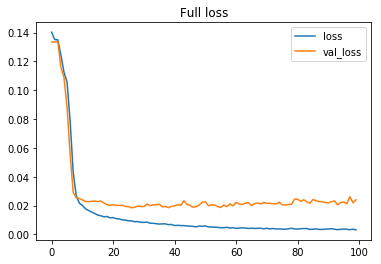

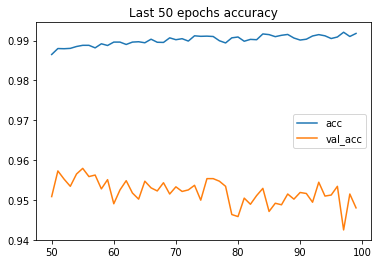

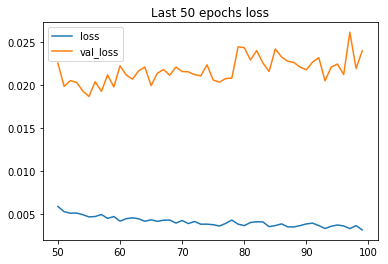

In [9]:
%matplotlib inline

history_df = pd.DataFrame(
    {'acc': history.history['acc'],
     'val_acc': history.history['val_acc'],
     'loss': history.history['loss'],
     'val_loss': history.history['val_loss']
    })

print(history_df.describe())

history_df[['acc', 'val_acc']].plot(title='Full accuracy')
history_df[['loss', 'val_loss']].plot(title='Full loss')
history_df[['acc', 'val_acc']][-50:].plot(title='Last 50 epochs accuracy')
history_df[['loss', 'val_loss']][-50:].plot(title='Last 50 epochs loss')

In [10]:
best_model = keras.models.load_model(PATH_TO_BEST_MODEL)

In [11]:
best_model.evaluate(test_data, test_labels)

7780/7780 [==============================] - 0s 58us/step


[0.015829188602311604, 0.9634961439588688]

In [12]:
best_model.predict(test_data[0:1])

array([[1.3052115e-30, 1.0000000e+00, 5.3505539e-23, 2.8245502e-15]],
      dtype=float32)